In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pickle
import numpy as np
import collections
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
with open(r'..\Dataset3\Dataset3Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'..\Dataset3\Dataset3Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'..\Dataset3\Dataset3Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'..\Dataset3\Dataset3Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'..\Dataset3\Dataset3Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'..\Dataset3\Dataset3Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [3]:
print(collections.Counter(y_train))
print(collections.Counter(y_val))
print(collections.Counter(y_test))

Counter({'food and drinks': 19189, 'real estate': 19149, 'family and relationships': 19073, 'news and politics': 19041, 'sports': 19031, 'style and fashion': 19003, 'arts and culture': 19002, 'hobbies and interests': 18981, 'business and finance': 18977, 'healthy living': 18954})
Counter({'news and politics': 4888, 'style and fashion': 4799, 'hobbies and interests': 4795, 'sports': 4761, 'arts and culture': 4755, 'family and relationships': 4752, 'business and finance': 4737, 'healthy living': 4717, 'real estate': 4710, 'food and drinks': 4686})
Counter({'healthy living': 4329, 'business and finance': 4286, 'arts and culture': 4243, 'hobbies and interests': 4224, 'sports': 4208, 'style and fashion': 4198, 'family and relationships': 4175, 'real estate': 4141, 'food and drinks': 4125, 'news and politics': 4071})


In [4]:
np.unique(y_train)

array(['arts and culture', 'business and finance',
       'family and relationships', 'food and drinks', 'healthy living',
       'hobbies and interests', 'news and politics', 'real estate',
       'sports', 'style and fashion'], dtype=object)

In [5]:
encoder = LabelEncoder()
encoder.fit(np.unique(y_train))

LabelEncoder()

In [6]:
encoder.classes_

array(['arts and culture', 'business and finance',
       'family and relationships', 'food and drinks', 'healthy living',
       'hobbies and interests', 'news and politics', 'real estate',
       'sports', 'style and fashion'], dtype=object)

In [7]:
train_labels = encoder.transform(y_train)
val_labels = encoder.transform(y_val)
test_labels = encoder.transform(y_test)

In [8]:
train_labels[0:5]

array([2, 1, 7, 5, 7])

In [9]:
y_train[0:5]

array(['family and relationships', 'business and finance', 'real estate',
       'hobbies and interests', 'real estate'], dtype=object)

In [10]:
num_classes = len(encoder.classes_)
train_one_hot = keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_one_hot = keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_one_hot = keras.utils.to_categorical(test_labels, num_classes=num_classes)

In [11]:
with open(r'..\Dataset3\embeddingMatrixDS3.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

In [12]:
num_tokens = 483568 # total vocabulary +1
embedding_dim = 300 # dimension of the vector of a single word
MAX_REVIEW_LEN = 500 # maximum words in a review

In [24]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True
)

In [25]:
tf.random.set_seed(0)
model = keras.Sequential()
model.add(embedding_layer)
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
#model.add(keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

callback_trigger = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train, train_one_hot, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, val_one_hot), callbacks=[callback_trigger])

Epoch 1/25
1488/1488 [==============================] - 39s 26ms/step - loss: 1.0462 - accuracy: 0.6845 - val_loss: 0.6702 - val_accuracy: 0.8038
Epoch 2/25
1488/1488 [==============================] - 38s 26ms/step - loss: 0.4940 - accuracy: 0.8553 - val_loss: 0.5611 - val_accuracy: 0.8323
Epoch 3/25
1488/1488 [==============================] - 38s 26ms/step - loss: 0.3195 - accuracy: 0.9053 - val_loss: 0.5453 - val_accuracy: 0.8387
Epoch 4/25
1488/1488 [==============================] - 38s 26ms/step - loss: 0.2099 - accuracy: 0.9384 - val_loss: 0.5860 - val_accuracy: 0.8354
Epoch 5/25
1488/1488 [==============================] - 39s 26ms/step - loss: 0.1343 - accuracy: 0.9617 - val_loss: 0.6914 - val_accuracy: 0.8247


In [27]:
score = model.evaluate(X_test, test_one_hot, verbose=1)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

1313/1313 [==============================] - 2s 2ms/step - loss: 0.6779 - accuracy: 0.8257
Test score:  0.6779451370239258
Test accuracy:  0.8257142901420593


In [30]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(test_one_hot, axis=1)

1313/1313 [==============================] - 1s 853us/step


In [31]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('SNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

SNN accuracy is 82.57%
------------------------------------------------
Confusion Matrix:


TypeError: 'numpy.ndarray' object is not callable

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

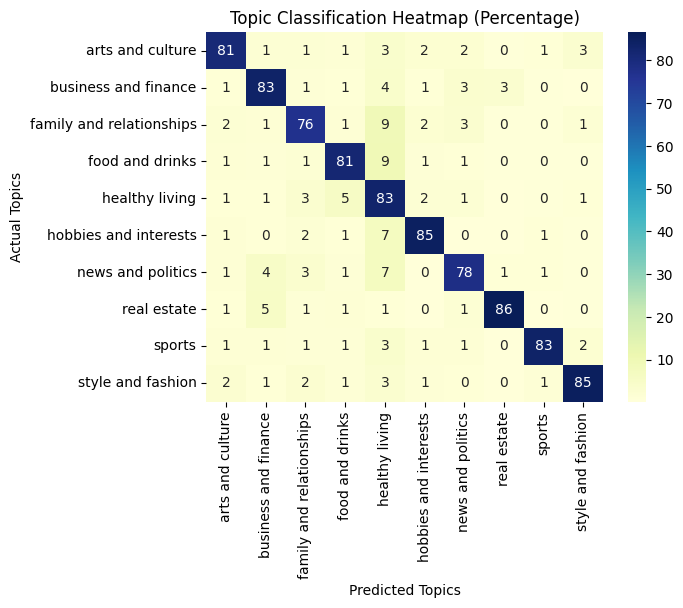

In [33]:
# Create a confusion matrix
confusion_matrix = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# Set the title and axis labels
plt.title("Topic Classification Heatmap (Percentage)")
plt.xlabel("Predicted Topics")
plt.ylabel("Actual Topics")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the heatmap
plt.show()